### Imports, Classes and Functions

In [5]:
import gc
import math
import time

import torch
import numpy as np
import pandas as pd
import torch._dynamo
import torch.nn as nn
import scipy.stats as stats
import torch.optim as optim
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision("high")
torch._functorch.config.donated_buffer=False
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 14,
    'figure.dpi': 100,
    'legend.loc': 'upper left',
})

In [6]:
def generate_collocation_points(n_samples, spot_bounds, strike_bounds,
                                tau_bounds, rate_bounds, dividend_bounds,
                                moneyness_bounds, moneyness_mean, seed=SEED):

    rng = np.random.RandomState(seed)

    n_atm = int(n_samples * ATM_COLLOC_SAMPLING)
    atm_moneyness_bounds = (0.97, 1.03)

    if n_atm > 0:
        s_atm = rng.uniform(*spot_bounds, size=n_atm)
        m_atm = rng.uniform(*atm_moneyness_bounds, size=n_atm)
        k_atm = s_atm / m_atm

        valid_mask = (k_atm >= strike_bounds[0]) * (k_atm <= strike_bounds[1])
        s_atm, k_atm = s_atm[valid_mask], k_atm[valid_mask]

        n_atm = len(s_atm)

        tau_atm = rng.uniform(*tau_bounds, size=n_atm)
        t_atm = ((90/365.25) - tau_atm)
        r_atm = rng.uniform(*rate_bounds, size=n_atm)
        d_atm = rng.uniform(*dividend_bounds, size=n_atm)

        X_atm = np.stack([s_atm, k_atm, t_atm, r_atm, d_atm], axis=1)
    else:
        X_atm = np.array([]).reshape(0, 5)

    n_regular = n_samples - n_atm
    X_regular = np.empty((n_regular, 5))
    filled = 0

    batch_size = min(25_000, max(1_000, 2 * n_regular))

    while filled < n_regular:

        s_points = rng.uniform(*spot_bounds, size=(batch_size))

        u_m = rng.uniform(0, 1, size=(batch_size))
        m_points = moneyness_bounds[0] + (moneyness_bounds[1] - moneyness_bounds[0]) * (u_m**M_SKEW)

        k_points = s_points/m_points

        valid_mask = (
            (m_points >= moneyness_bounds[0]) &
            (m_points <= moneyness_bounds[1]) &
            (k_points >= strike_bounds[0]) &
            (k_points <= strike_bounds[1])
        )

        s = s_points[valid_mask]
        k = k_points[valid_mask]

        num_valid = len(s)
        if num_valid == 0:
            continue

        u = rng.uniform(0, 1, size=(batch_size))
        tau = tau_bounds[0] + (tau_bounds[1] - tau_bounds[0]) * (u**T_SKEW)

        t = ((90/365.25) - tau)
        r = rng.uniform(*rate_bounds, size=(batch_size))
        d = rng.uniform(*dividend_bounds, size=(batch_size))

        take = min(num_valid, n_regular - filled)

        X_regular[filled:filled+take, 0] = s[:take]
        X_regular[filled:filled+take, 1] = k[:take]
        X_regular[filled:filled+take, 2] = t[:take]
        X_regular[filled:filled+take, 3] = r[:take]
        X_regular[filled:filled+take, 4] = d[:take]

        filled += take

    X = np.vstack([X_regular, X_atm])
    rng.shuffle(X)

    return X


def generate_tc_points(n_samples, atm_sampling, spot_bounds, strike_bounds, tau_bounds, rate_bounds, dividend_bounds, seed=SEED):
    rng = np.random.RandomState(seed)

    if atm_sampling > 0:
        n_atm = n_samples
        atm_moneyness_bounds = (0.97, 1.03)

        s_atm = rng.uniform(*spot_bounds, size=n_atm)
        m_atm = rng.uniform(*atm_moneyness_bounds, size=n_atm)
        k_atm = s_atm / m_atm

        valid_mask = (k_atm >= strike_bounds[0]) * (k_atm <= strike_bounds[1])
        s_atm, k_atm = s_atm[valid_mask], k_atm[valid_mask]

        s = np.vstack([s_atm.reshape(-1, 1)])
        k = np.vstack([k_atm.reshape(-1, 1)])

        l = np.full(len(s), "terminal_atm", dtype="<U7")

    else:
        n_regular = n_samples
        s_regular = rng.uniform(*spot_bounds, size=(n_regular, 1))
        k_regular = rng.uniform(*strike_bounds, size=(n_regular, 1))

        s = np.vstack([s_regular.reshape(-1, 1)])
        k = np.vstack([k_regular.reshape(-1, 1)])

        l = np.full(len(s), "terminal_regular", dtype="<U7")

    current_n_samples = len(s)
    t = np.full((current_n_samples, 1), (90/365.25))
    r = rng.uniform(*rate_bounds, size=(current_n_samples, 1))
    q = rng.uniform(*dividend_bounds, size=(current_n_samples, 1))
    i = np.zeros((current_n_samples, 1))

    X_tc = np.hstack([s, k, t, r, q, i])
    Y_tc = np.maximum(s - k, 0.0)
    terminal_labels = l

    return X_tc, Y_tc, terminal_labels


def generate_bc_points(n_samples, spot_bounds, strike_bounds, tau_bounds, rate_bounds, dividend_bounds, seed=SEED):
    rng = np.random.RandomState(seed)

    n_s0 = n_samples // 2

    S = np.zeros((n_s0, 1))
    K = rng.uniform(*strike_bounds, size=(n_s0, 1))
    tau = rng.uniform(*tau_bounds, size=(n_s0, 1))
    t = ((90/365.25) - tau)
    r = rng.uniform(*rate_bounds, size=(n_s0, 1))
    q = rng.uniform(*dividend_bounds, size=(n_s0, 1))
    i = np.zeros((n_s0, 1))
    X_s0 = np.hstack([S, K, t, r, q, i])
    Y_s0 = np.zeros((n_s0, 1))

    n_sinf = n_samples - n_s0
    large_spot_val = strike_bounds[1] * 4

    S = np.full((n_sinf, 1), large_spot_val)
    K = rng.uniform(*strike_bounds, size=(n_sinf, 1))
    tau = rng.uniform(*tau_bounds, size=(n_sinf, 1))
    t = ((90/365.25) - tau)
    r = rng.uniform(*rate_bounds, size=(n_sinf, 1))
    q = rng.uniform(*dividend_bounds, size=(n_sinf, 1))
    i = np.zeros((n_sinf, 1))

    X_smax = np.hstack([S, K, t, r, q, i])
    Y_smax = S * np.exp(-q * tau) - K * np.exp(-r * tau)

    b_s0_labels = np.full(len(X_s0), "null", dtype="<U7")
    b_max_labels = np.full(len(X_smax), "max", dtype="<U7")

    return X_s0, X_smax, Y_s0, Y_smax, b_s0_labels, b_max_labels


def create_train_test_split(market_data, terminal_boundary_data, train_ratio=0.8, val_ratio=0.1, seed=SEED):

    test_ratio = 1.0 - train_ratio - val_ratio
    train_sets, val_sets, test_sets = {}, {}, {}


    X_market, Y_market, market_labels = market_data
    X_m_train, X_m_rem, Y_m_train, Y_m_rem, labels_m_train, labels_m_rem = train_test_split(
        X_market, Y_market, market_labels,
        train_size=train_ratio, stratify=market_labels, random_state=seed
    )

    relative_test_size = test_ratio / (val_ratio + test_ratio)
    X_m_val, X_m_test, Y_m_val, Y_m_test = train_test_split(
        X_m_rem, Y_m_rem,
        test_size=relative_test_size, stratify=labels_m_rem, random_state=seed
    )

    train_sets['market'] = (X_m_train, Y_m_train)
    val_sets['market'] = (X_m_val, Y_m_val)
    test_sets['market'] = (X_m_test, Y_m_test)

    for name, (X, Y, L) in terminal_boundary_data.items():
        X_train, X_rem, Y_train, Y_rem, labels_t_b_train, labels_t_b_rem = train_test_split(
            X, Y, L, train_size=train_ratio, stratify=L, random_state=seed
        )

        X_val, X_test, Y_val, Y_test = train_test_split(
            X_rem, Y_rem,
            test_size=relative_test_size, stratify=labels_t_b_rem, random_state=seed
        )

        train_sets[name] = (X_train, Y_train)
        val_sets[name] = (X_val, Y_val)
        test_sets[name] = (X_test, Y_test)

    all_X_val = np.vstack([arr[0] for arr in val_sets.values()])
    all_Y_val = np.vstack([arr[1] for arr in val_sets.values()])

    all_X_test = np.vstack([arr[0] for arr in test_sets.values()])
    all_Y_test = np.vstack([arr[1] for arr in test_sets.values()])

    all_X_train = np.vstack([arr[0] for arr in train_sets.values()])
    all_Y_train = np.vstack([arr[1] for arr in train_sets.values()])

    x_min = all_X_train.min(axis=0)
    x_min = x_min[0:5]
    x_max = all_X_train.max(axis=0)
    x_max = x_max[0:5]
    x_range = x_max - x_min

    y_min = all_Y_train.min(axis=0)
    y_max = all_Y_train.max(axis=0)
    y_range = y_max - y_min

    return train_sets, test_sets, (all_X_val, all_Y_val), (all_X_test, all_Y_test), x_min, x_range, y_min, y_range

In [38]:
class MLP(nn.Module):
    def __init__(self, layers):
        super().__init__()
        mods = []
        for i in range(len(layers) - 2):
            mods.append(nn.Linear(layers[i], layers[i + 1]))
            mods.append(nn.Tanh())
        mods.append(nn.Linear(layers[-2], layers[-1]))
        self.net = nn.Sequential(*mods).to(DEVICE)

        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

class PINN(nn.Module):
    def __init__(self, layers, y_min, y_range, x_min, x_range):
        super().__init__()

        self.net = MLP(layers)
        self.softplus = nn.Softplus()

        self.register_buffer("y_min",   torch.tensor(y_min,   dtype=torch.float32))
        self.register_buffer("y_range", torch.tensor(y_range, dtype=torch.float32))
        self.register_buffer("x_min",   torch.tensor(x_min,   dtype=torch.float32))
        self.register_buffer("x_range", torch.tensor(x_range, dtype=torch.float32))

        self.register_buffer("sigma_min", torch.tensor(0.0422, dtype=torch.float32))
        self.register_buffer("sigma_max", torch.tensor(1.8383, dtype=torch.float32))

    def forward(self, x_norm):

        output = self.net(x_norm)
        pred_norm_V, sigma = output.split(1, dim=1)

        V = self.softplus(pred_norm_V) * self.y_range + self.y_min
        sigma = self.sigma_min + (self.sigma_max - self.sigma_min) * self.softplus(sigma)

        return V, sigma

    def pde_res(self, Xc, Xc_norm):

        _, V, sigma = self.forward(Xc_norm)

        grads = torch.autograd.grad(V, Xc, torch.ones_like(V), create_graph=True, retain_graph=True)
        dV_dS = grads[0][:, 0:1]
        dV_dt = grads[0][:, 2:3]

        hess = torch.autograd.grad(dV_dS, Xc, torch.ones_like(dV_dS), create_graph=True, retain_graph=True)
        d2V_dS2 = hess[0][:, 0:1]

        S = Xc[:, 0:1]
        r = Xc[:, 3:4]
        q = Xc[:, 4:5]

        res = (dV_dt + 0.5 * sigma**2 * S**2 * d2V_dS2 + (r - q) * S * dV_dS - r * V)
        return res

In [8]:
def black_scholes_call(spot, strike, t, risk_free, dividend, sigma):
    t = np.maximum(t, 1e-8)
    d1 = (np.log(spot / strike) + (risk_free - dividend + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))

    d2 = d1 - sigma * np.sqrt(t)

    result = spot * np.exp(-dividend * t) * stats.norm.cdf(d1) - strike * np.exp(-risk_free * t) * stats.norm.cdf(d2)

    return result

In [9]:
def calculate_metrics(y_true, y_pred):
    errors = y_true - y_pred
    
    mse = np.mean(errors ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(errors))
    
    metrics = {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae
    }
    
    return metrics

In [10]:
def plot_3d_surface_with_scatter(grid_x, grid_y, grid_z, 
                                 scatter_x, scatter_y, scatter_z, 
                                 title, xlabel, ylabel, zlabel):
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    surface = ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis', alpha=0.7, rstride=5, cstride=5)
    
    scatter = ax.scatter(scatter_x, scatter_y, scatter_z, s=10, label='Reale Marktdaten')
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    #ax.legend()
    fig.colorbar(surface, shrink=0.5, aspect=5, label=zlabel)
    plt.show()
    
def plot_3d_surface_with_scatter(grid_x, grid_y, grid_z,
                                 scatter_x, scatter_y, scatter_z,
                                 title, xlabel, ylabel, zlabel):

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    surface = ax.plot_surface(grid_x, grid_y, grid_z, alpha=0.5, rstride=5, cstride=5, cmap='viridis', zorder=1)
    ax.scatter(scatter_x, scatter_y, scatter_z, s=12, alpha=0.5, zorder=2, edgecolor='k', depthshade=False)

    ax.set_title('')
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    #ax.set_zlabel(zlabel)
    
    fig.colorbar(surface, shrink=0.5, aspect=5, label=zlabel)
    #ax.view_init(elev=25, azim=90)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig("call_surface.pdf", bbox_inches="tight")
    plt.show()


### Sampling and Model Loading

In [11]:
df = pd.read_csv(r'filtered_data.csv')
call_df = df[df['Option_Type'] == 'call'].copy()
call_df.drop(columns=['Unnamed: 0'], inplace=True)

call_df.loc[:, 'Dividend_Yield'] = call_df['Dividend_Yield'] / 100
call_df.loc[:, 'RF'] = call_df['RF'] / 100
call_df.loc[:, 'Implied_Volatility'] = call_df['Implied_Volatility'] / 100

max_tau = 90/365.25
call_df.loc[:, 't'] = max_tau - call_df['Time_to_Exp']
call_df = call_df[call_df['Time_to_Exp'] <= max_tau]

moneyness_labels = ['ITM', 'ATM', 'OTM']
moneyness_conditions = [
    call_df['Moneyness'] > 1.03,
    (call_df['Moneyness'] >= 0.97) & (call_df['Moneyness'] <= 1.03),
    call_df['Moneyness'] < 0.97
]
call_df['moneyness_labels'] = np.select(moneyness_conditions, moneyness_labels, default='Other')

X_market = call_df[['Underlying_Price', 'Strike', 't', 'RF', 'Dividend_Yield', 'Implied_Volatility']].to_numpy()
market_moneyness_labels = call_df['moneyness_labels'].to_numpy()
Y_market = call_df[['Option_Price']].to_numpy()

spot_bounds = (call_df['Underlying_Price'].min(), call_df['Underlying_Price'].max())
strike_bounds = (call_df['Strike'].min(), call_df['Strike'].max())
time_bounds = (call_df['t'].min(), call_df['t'].max())
rate_bounds = (call_df['RF'].min(), call_df['RF'].max())
dividend_bounds = (call_df['Dividend_Yield'].min(), call_df['Dividend_Yield'].max())
moneyness_bounds = (call_df['Moneyness'].min(), call_df['Moneyness'].max())
moneyness_mean = call_df['Moneyness'].mean()

print(f"{call_df['moneyness_labels'].value_counts(normalize=True)}\n")

print(f"95% Implied Volatility: {call_df['Implied_Volatility'].quantile(0.95)}")
print(f"99% Implied Volatility: {call_df['Implied_Volatility'].quantile(0.99)}")
print(f"99.5% Implied Volatility: {call_df['Implied_Volatility'].quantile(0.995)}")
print(f"99.9% Implied Volatility: {call_df['Implied_Volatility'].quantile(0.999)}\n")

call_df.describe()

moneyness_labels
OTM    0.430482
ATM    0.412169
ITM    0.157349
Name: proportion, dtype: float64

95% Implied Volatility: 0.38361329999999993
99% Implied Volatility: 0.750424120000005
99.5% Implied Volatility: 0.8406999999999999
99.9% Implied Volatility: 1.082679046000001



,Option_Price,Option_Volume,Strike,Time_to_Exp,Implied_Volatility,RF,Underlying_Price,Dividend_Yield,Moneyness,t
count,81799.000000,81799.000000,81799.000000,81799.000000,81799.000000,81799.000000,81799.000000,81799.000000,81799.000000,81799.000000
mean,89.553829,706.105380,4135.340713,0.071293,0.195208,0.024592,4021.372881,0.020655,0.978205,0.175113
std,177.147702,2045.446545,919.728490,0.050372,0.115878,0.021081,863.316724,0.003202,0.085042,0.050372
min,0.010000,10.000000,1800.000000,0.005476,0.042290,-0.000460,2237.400000,0.014950,0.545707,0.000000
25%,1.600000,26.000000,3370.000000,0.038330,0.125900,0.001090,3339.190000,0.018132,0.938821,0.158795
50%,21.590000,87.000000,4170.000000,0.062971,0.168027,0.023690,4006.180000,0.020652,0.979504,0.183436
75%,101.240000,387.000000,4740.000000,0.087611,0.224894,0.047030,4510.040000,0.022652,1.010923,0.208077
max,2025.060000,56929.000000,6000.000000,0.246407,1.838388,0.055030,6090.270000,0.034420,1.499685,0.240931


In [40]:
R_M = 0.60
R_T = 0.35
ATM_TC_SAMPLING = 0.25
ATM_COLLOC_SAMPLING = 0.30
T_SKEW=1.4
M_SKEW=1.5

n_samples = int(len(X_market))
n_colloc = int(n_samples * 2.0)
n_bc = int(n_samples * 3.0)
n_tc = int(n_samples * (3.0 - ATM_TC_SAMPLING))
n_tc_atm = int(n_samples * (ATM_TC_SAMPLING + 0.007))

spot_bounds = spot_bounds
strike_bounds = strike_bounds
tau_bounds = (0, 90/365.25)
rate_bounds = rate_bounds
dividend_bounds = dividend_bounds
moneyness_bounds = moneyness_bounds
moneyness_mean = moneyness_mean

Xc_pool = generate_collocation_points(n_colloc, spot_bounds, strike_bounds, time_bounds, rate_bounds, dividend_bounds, moneyness_bounds, moneyness_mean)
X_t, Y_t, t_regular_labels = generate_tc_points(n_tc, 0.0, spot_bounds, strike_bounds, time_bounds, rate_bounds, dividend_bounds)
X_t_atm, Y_t_atm, t_atm_labels = generate_tc_points(n_tc_atm, ATM_TC_SAMPLING, spot_bounds, strike_bounds, time_bounds, rate_bounds, dividend_bounds)

diff = int(n_samples*3.0) - n_tc
X_t_atm, Y_t_atm, t_atm_labels = X_t_atm[:diff], Y_t_atm[:diff], t_atm_labels[:diff]
X_b_s0, X_b_smax, Y_b_s0, Y_b_smax, b_s0_labels, b_smax_labels = generate_bc_points(n_bc, spot_bounds, strike_bounds, time_bounds, rate_bounds, dividend_bounds)

terminal_boundary_data = {"terminal": (X_t, Y_t, t_regular_labels),
                          "terminal_atm": (X_t_atm, Y_t_atm, t_atm_labels),
                          "boundary_smax": (X_b_smax, Y_b_smax, b_smax_labels),
                          "boundary_s0": (X_b_s0, Y_b_s0, b_s0_labels)}

market_data = (X_market, Y_market, market_moneyness_labels)

train_sets_dict, test_sets_dict, val_sets_arr, test_sets_arr, x_min, x_range, y_min, y_range = create_train_test_split(
    market_data, terminal_boundary_data,
    train_ratio=0.8, val_ratio=0.1, seed=SEED
)

X_val, Y_val = val_sets_arr[0][:, 0:5], val_sets_arr[1]
X_test, Y_test = test_sets_arr[0][:, 0:5], test_sets_arr[1]

net = PINN([5, 148, 148, 148, 148, 148, 148, 2], y_min, y_range, x_min, x_range).to(DEVICE)
net = torch.compile(net, mode="default")

In [41]:
net.load_state_dict(torch.load(f"net_call_tanh_6_148_50000.pth", weights_only=True))
net.eval()

OptimizedModule(
  (_orig_mod): PINN(
    (net): MLP(
      (net): Sequential(
        (0): Linear(in_features=5, out_features=148, bias=True)
        (1): Tanh()
        (2): Linear(in_features=148, out_features=148, bias=True)
        (3): Tanh()
        (4): Linear(in_features=148, out_features=148, bias=True)
        (5): Tanh()
        (6): Linear(in_features=148, out_features=148, bias=True)
        (7): Tanh()
        (8): Linear(in_features=148, out_features=148, bias=True)
        (9): Tanh()
        (10): Linear(in_features=148, out_features=148, bias=True)
        (11): Tanh()
        (12): Linear(in_features=148, out_features=2, bias=True)
      )
    )
    (softplus): Softplus(beta=1.0, threshold=20.0)
  )
)

### Test Data Set

In [15]:
X_arr_test = test_sets_dict['market'][0]
Y_arr_test = test_sets_dict['market'][1]
arr_test = np.hstack([X_arr_test, Y_arr_test])

In [16]:
test_df = pd.DataFrame(arr_test)
test_df.columns = ["Spot", "Strike", "Time", "Rate", "Dividend", "Implied Volatility", "Option Price"]
test_df['Moneyness'] = test_df['Spot'] / test_df['Strike']
test_df.describe()

,Spot,Strike,Time,Rate,Dividend,Implied Volatility,Option Price,Moneyness
count,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000
mean,4024.744988,4139.039731,0.175488,0.024767,0.020638,0.195212,90.416608,0.978282
std,857.746999,917.363511,0.050237,0.021063,0.003163,0.115652,180.482004,0.085588
min,2237.400000,1800.000000,0.005476,-0.000460,0.014989,0.042290,0.010000,0.619068
25%,3351.280000,3390.000000,0.158795,0.001120,0.018130,0.125475,1.520000,0.937945
50%,4023.890000,4180.000000,0.183436,0.023730,0.020620,0.168512,20.965000,0.978960
75%,4513.040000,4750.000000,0.216290,0.047410,0.022626,0.225048,103.440000,1.011875
max,6075.110000,6000.000000,0.240931,0.055030,0.034420,1.204577,2007.580000,1.499685


In [17]:
X_test_bsm = test_df.iloc[:, :6].to_numpy()
X_test_net = torch.from_numpy(X_arr_test[:, 0:5]).float().to(DEVICE)
X_test_norm = 2 * (X_test_net - net.x_min) / net.x_range - 1

Y_test = Y_arr_test

In [18]:
bsm_prices_test = black_scholes_call(X_test_bsm[:,0],
                                     X_test_bsm[:,1],
                                     X_test_bsm[:,2],
                                     X_test_bsm[:,3],
                                     X_test_bsm[:,4],
                                     X_test_bsm[:,5])

In [19]:
with torch.no_grad():
    _, Y_pred, sigma_pred = net(X_test_norm)
    
Y_pred = Y_pred.cpu().numpy()
sigma_pred = sigma_pred.cpu().numpy()

W1026 20:02:41.468000 353 torch/_inductor/utils.py:1436] [0/0] Not enough SMs to use max_autotune_gemm mode


### FQ1

In [27]:
otm_threshold = test_df['Moneyness'].quantile(0.05)
itm_threshold = test_df['Moneyness'].quantile(0.95)
is_extreme_moneyness = (test_df['Moneyness'] <= otm_threshold) | (test_df['Moneyness'] >= itm_threshold)

short_term_threshold = test_df['Time'].quantile(0.05)
is_short_term = (test_df['Time'] <= short_term_threshold)

high_spot_threshold = test_df['Spot'].quantile(0.95)
is_extreme_spot = (test_df['Spot'] >= high_spot_threshold) | (test_df['Spot'] == 0)

high_iv_threshold = test_df['Implied Volatility'].quantile(0.95)
is_extreme_iv = (test_df['Implied Volatility'] >= high_iv_threshold)

In [80]:
final_filter = is_extreme_moneyness | is_short_term | is_extreme_spot | is_extreme_iv
test_df_extrem = test_df[final_filter]
test_df_extrem.describe()

,Spot,Strike,Time,Rate,Dividend,Implied Volatility,Option Price,Moneyness
count,1638.000000,1638.000000,1638.000000,1638.000000,1638.000000,1638.000000,1638.000000,1638.000000
mean,4286.836239,4385.131258,0.139147,0.026330,0.020214,0.299649,239.453114,0.996128
std,1106.329425,1192.158903,0.073394,0.021908,0.004364,0.197753,334.233879,0.162861
min,2237.400000,1800.000000,0.005476,-0.000460,0.014989,0.079823,0.010000,0.619068
25%,3385.490000,3255.000000,0.062971,0.001370,0.015835,0.158985,0.655000,0.846318
50%,4137.465000,4535.000000,0.158795,0.024505,0.019884,0.240021,90.325000,0.992006
75%,5608.250000,5570.000000,0.202601,0.046610,0.022431,0.381725,354.982500,1.102020
max,6075.110000,6000.000000,0.240931,0.054770,0.034420,1.204577,2007.580000,1.499685


In [29]:
S_mean = test_df_extrem['Spot'].mean()
r_mean = test_df_extrem['Rate'].mean()
q_mean = test_df_extrem['Dividend'].mean()

K_range = np.linspace(test_df_extrem['Strike'].min(), test_df_extrem['Strike'].max(), 100)
T_range = np.linspace(test_df_extrem['Time'].min(), test_df_extrem['Time'].max(), 100)
K_grid, T_grid = np.meshgrid(K_range, T_range)

K_flat = K_grid.flatten()
T_flat = T_grid.flatten()
N = len(K_flat)

net_input_extrem = torch.zeros(N, 5, dtype=torch.float32)
net_input_extrem[:, 0] = torch.full((N,), S_mean)
net_input_extrem[:, 1] = torch.tensor(K_flat, dtype=torch.float32)
net_input_extrem[:, 2] = torch.tensor(T_flat, dtype=torch.float32)
net_input_extrem[:, 3] = torch.full((N,), r_mean)
net_input_extrem[:, 4] = torch.full((N,), q_mean)
net_input_extrem = net_input_extrem.to(DEVICE)
net_input_exreme_norm = 2 * (net_input_extrem - net.x_min) / net.x_range - 1

with torch.no_grad():
    _, y_pred_extreme, _ = net(net_input_exreme_norm)
    
price_surface_extreme = y_pred_extreme.cpu().numpy().reshape(K_grid.shape)

In [72]:
test_df_arr = test_df_extrem.to_numpy()
X_test_extrem = torch.from_numpy(test_df_arr[:, 0:5]).float().to(DEVICE)
X_test_extrem_norm = 2*(X_test_extrem - net.x_min) / net.x_range - 1
X_test_extrem_bsm = test_df_arr[:, 0:6]
Y_test_extrem = test_df_arr[:, 6:7]

In [73]:
bsm_prices_test = black_scholes_call(X_test_extrem_bsm[:,0],
                                     X_test_extrem_bsm[:,1],
                                     X_test_extrem_bsm[:,2],
                                     X_test_extrem_bsm[:,3],
                                     X_test_extrem_bsm[:,4],
                                     X_test_extrem_bsm[:,5])

In [74]:
with torch.no_grad():
    _, Y_pred_extrem, _ = net(X_test_extrem_norm)
    
Y_pred_extrem = Y_pred_extrem.cpu().numpy()

In [81]:
metrics_pinn = calculate_metrics(Y_test_extrem, Y_pred_extrem)
print(f"Metriken PINN Call: {metrics_pinn}")

metrics_bs = calculate_metrics(bsm_prices_test, Y_pred_extrem)
print(f"Metriken BS Call: {metrics_bs}")

Metriken PINN Call: {'MSE': 273.09658900007673, 'RMSE': 16.525634299477787, 'MAE': 8.728481095770558}
Metriken BS Call: {'MSE': 240170.64892990282, 'RMSE': 490.0720854424406, 'MAE': 338.555728704155}


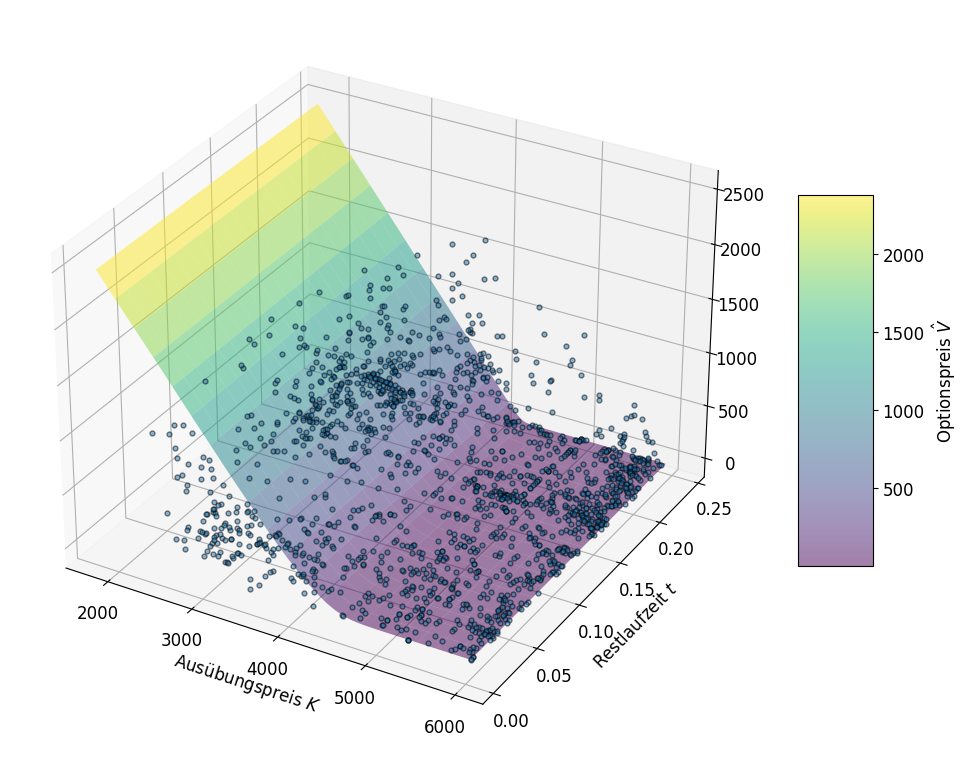

In [84]:
plot_3d_surface_with_scatter(
    grid_x=K_grid, grid_y=T_grid, grid_z=price_surface_extreme,
    scatter_x=test_df_extrem['Strike'],
    scatter_y=test_df_extrem['Time'],
    scatter_z=test_df_extrem['Option Price'],
    title='PINN Preisoberfläche vs. Reale Marktpreise',
    xlabel='Ausübungspreis $K$',
    ylabel='Restlaufzeit $t$',
    zlabel='Optionspreis $\hat{V}$'
)

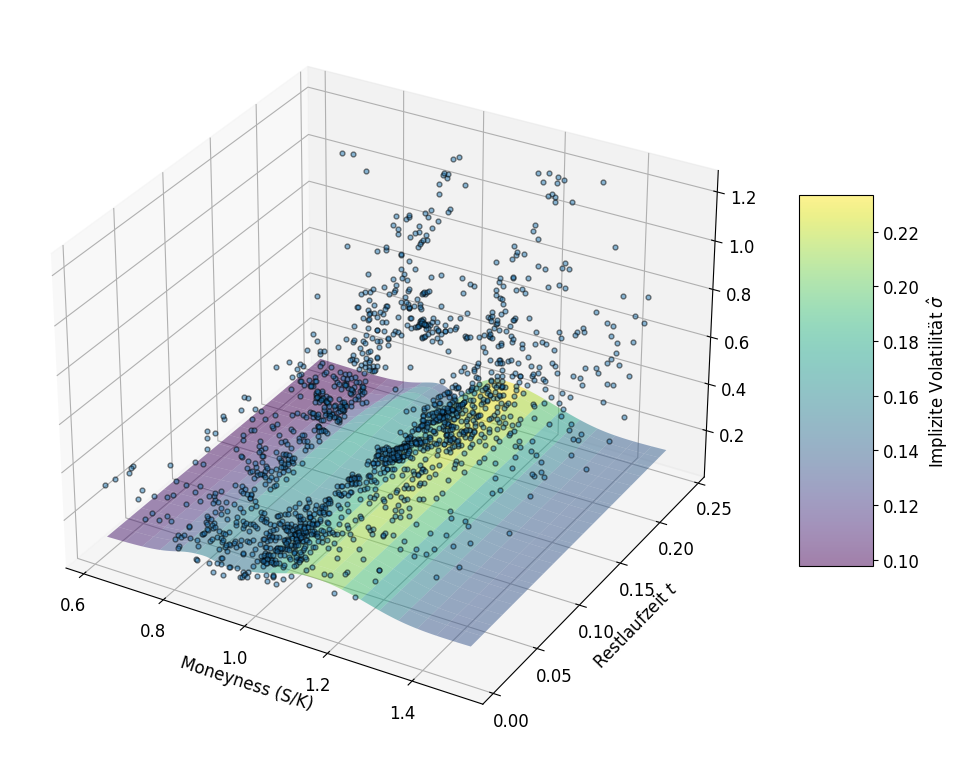

In [85]:
M_range = np.linspace(test_df_extrem['Moneyness'].min(), test_df_extrem['Moneyness'].max(), 100)
T_range_vol = np.linspace(test_df_extrem['Time'].min(), test_df_extrem['Time'].max(), 100)
M_grid, T_grid_vol = np.meshgrid(M_range, T_range_vol)

K_grid_from_M = S_mean / M_grid

K_flat_from_M = K_grid_from_M.flatten()
T_flat_vol = T_grid_vol.flatten()
N_vol = len(K_flat_from_M)

pinn_input_vol_extreme = torch.zeros(N_vol, 5, dtype=torch.float32)
pinn_input_vol_extreme[:, 0] = torch.full((N_vol,), S_mean)
pinn_input_vol_extreme[:, 1] = torch.tensor(K_flat_from_M, dtype=torch.float32)
pinn_input_vol_extreme[:, 2] = torch.tensor(T_flat_vol, dtype=torch.float32)
pinn_input_vol_extreme[:, 3] = torch.full((N_vol,), r_mean)
pinn_input_vol_extreme[:, 4] = torch.full((N_vol,), q_mean)
pinn_input_vol_extreme = pinn_input_vol_extreme.to(DEVICE)

net_input_vol_extreme = pinn_input_vol_extreme.to(DEVICE)
net_input_vol_extreme_norm = 2 * (net_input_vol_extreme - net.x_min) / net.x_range - 1

with torch.no_grad():
    _, _, sigma_pred_extreme = net(net_input_vol_extreme_norm)
    
vol_surface_extreme = sigma_pred_extreme.cpu().numpy().reshape(M_grid.shape)

plot_3d_surface_with_scatter(
    grid_x=M_grid, grid_y=T_grid_vol, grid_z=vol_surface_extreme,
    scatter_x=test_df_extrem['Moneyness'],
    scatter_y=test_df_extrem['Time'],
    scatter_z=test_df_extrem['Implied Volatility'],
    title='PINN Volatilitätsoberfläche vs. Reale Markt-IV',
    xlabel='Moneyness (S/K)',
    ylabel='Restlaufzeit $t$',
    zlabel='Implizite Volatilität $\hat{\sigma}$'
)

In [32]:
X_test_extreme_bsm = test_df_extrem.iloc[:, :6].to_numpy()
X_test_extreme_net = torch.from_numpy(X_test_extreme_bsm[:, :5]).float().to(DEVICE)
X_test_extreme_norm = 2 * (X_test_extreme_net - net.x_min) / net.x_range - 1

real_market_prices_extreme = test_df_extrem['Option Price'].values
real_market_iv_extreme = test_df_extrem['Implied Volatility'].values

bsm_prices_extreme = black_scholes_call(X_test_extreme_bsm[:,0],
                                        X_test_extreme_bsm[:,1],
                                        X_test_extreme_bsm[:,2],
                                        X_test_extreme_bsm[:,3],
                                        X_test_extreme_bsm[:,4],
                                        X_test_extreme_bsm[:,5])

with torch.no_grad():
    _, Y_pred_extreme, sigma_pred_extreme = net(X_test_extreme_norm)
    
Y_pred_extreme = Y_pred_extreme.cpu().numpy()
sigma_pred_extreme = sigma_pred_extreme.cpu().numpy()

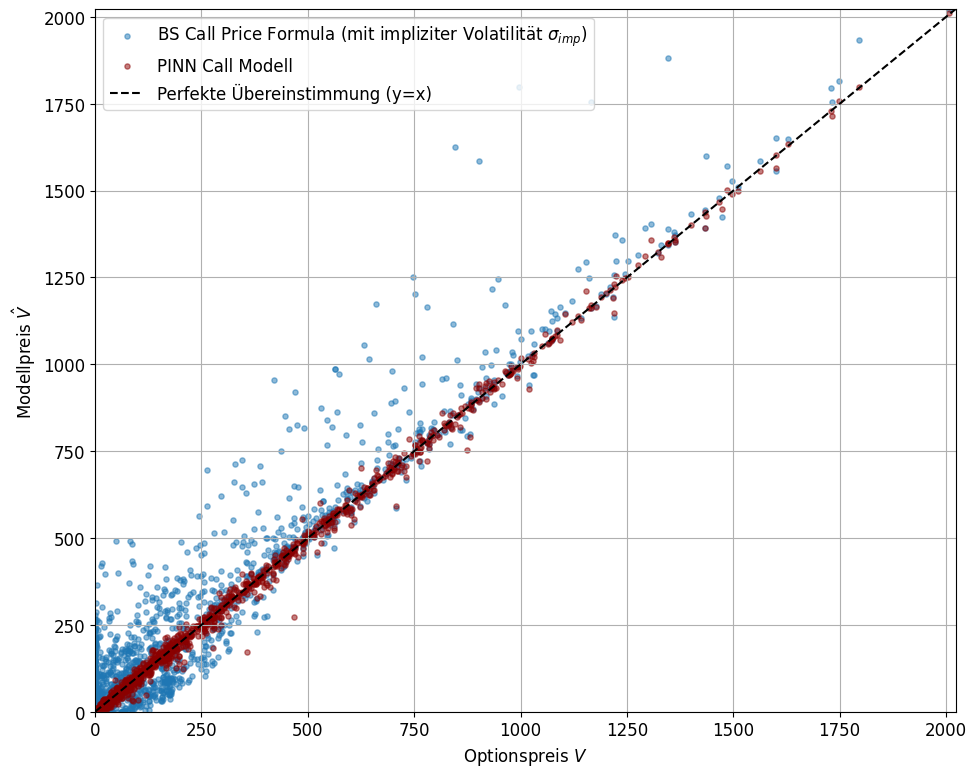

In [83]:
plt.figure(figsize=(10, 8))

plt.scatter(real_market_prices_extreme, bsm_prices_extreme, 
            label='BS Call Price Formula (mit impliziter Volatilität $\sigma_{imp}$)', 
            alpha=0.5, s=14)

plt.scatter(real_market_prices_extreme, Y_pred_extreme, 
            label=f'PINN Call Modell', 
            alpha=0.5, s=14, color='darkred')

min_val = min(real_market_prices_extreme.min(), Y_pred_extreme.min(), bsm_prices_extreme.min())
max_val = max(real_market_prices_extreme.max(), Y_pred_extreme.max(), bsm_prices_extreme.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', 
         label='Perfekte Übereinstimmung (y=x)')

#plt.title('Modellpreise vs. Reale Marktpreise (Datenarme Bereiche)')
plt.xlabel('Optionspreis $V$')
plt.ylabel('Modellpreis $\hat{V}$')
plt.legend()
plt.grid(True)
# plt.axis('equal') # Kann nützlich sein, aber die Achsen auch verzerren
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.tight_layout()
plt.savefig("call_pinn_bs_price.pdf", bbox_inches="tight")
plt.show()

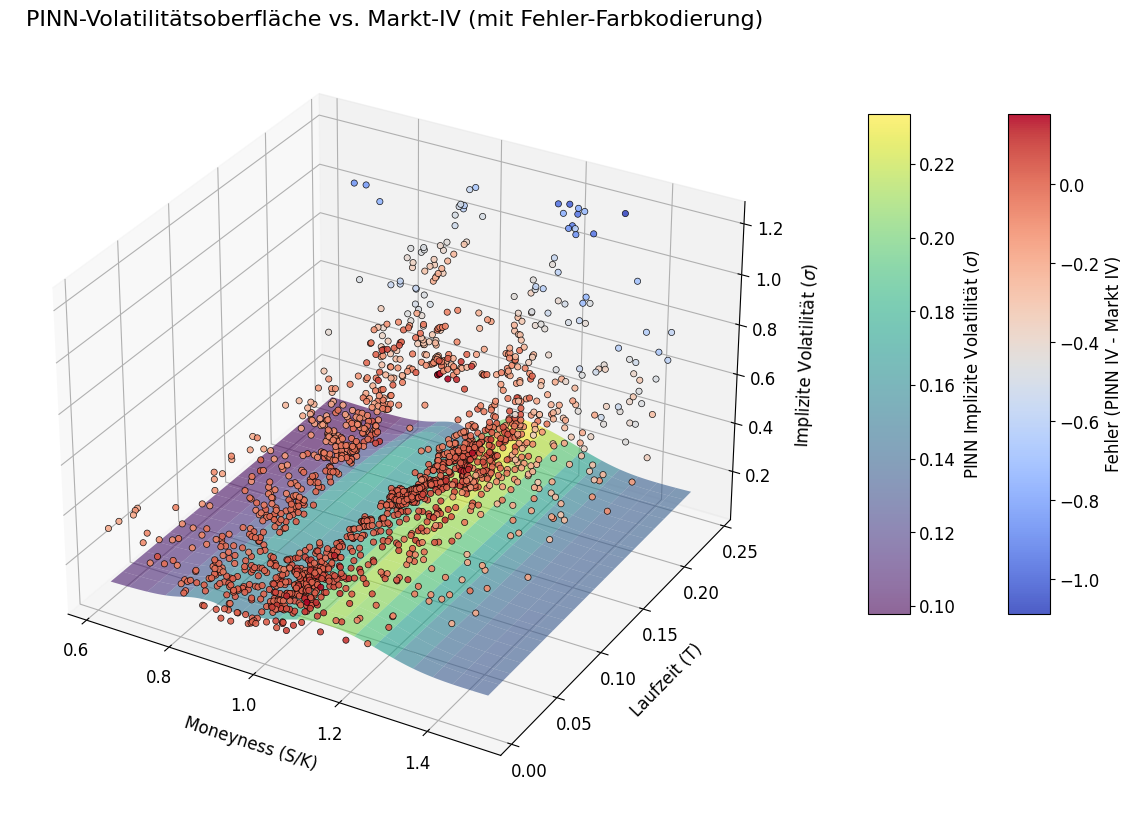

In [34]:
iv_error = np.squeeze(sigma_pred_extreme) - real_market_iv_extreme

x_scatter = test_df_extrem['Moneyness']
y_scatter = test_df_extrem['Time']
z_scatter = test_df_extrem['Implied Volatility']

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(M_grid, T_grid_vol, vol_surface_extreme,
                       cmap='viridis', alpha=0.6, rstride=5, cstride=5,
                       linewidth=0, antialiased=True)

norm = mcolors.Normalize(vmin=iv_error.min(), vmax=iv_error.max())
sc = ax.scatter(x_scatter, y_scatter, z_scatter, 
                c=iv_error, cmap='coolwarm', s=20, 
                edgecolors='k', linewidth=0.5, alpha=0.9,
                label='Reale Markt-IVs')

ax.set_title('PINN-Volatilitätsoberfläche vs. Markt-IV (mit Fehler-Farbkodierung)', fontsize=16)
ax.set_xlabel('Moneyness (S/K)', fontsize=12, labelpad=10)
ax.set_ylabel('Laufzeit (T)', fontsize=12, labelpad=10)
ax.set_zlabel('Implizite Volatilität ($\sigma$)', fontsize=12, labelpad=10)


cbar_surf_ax = fig.add_axes([0.85, 0.3, 0.03, 0.5]) # [links, unten, breite, höhe]
cbar_surf = fig.colorbar(surf, cax=cbar_surf_ax)
cbar_surf.set_label('PINN Implizite Volatilität ($\sigma$)', fontsize=12)

cbar_sc_ax = fig.add_axes([0.95, 0.3, 0.03, 0.5])
cbar_sc = fig.colorbar(sc, cax=cbar_sc_ax)
cbar_sc.set_label('Fehler (PINN IV - Markt IV)', fontsize=12)

plt.show()

### FQ2

In [24]:
metrics_pinn = calculate_metrics(Y_test, Y_pred)
print(f"Metriken PINN Call: {metrics_pinn}")

Metriken PINN Call: {'MSE': 116.62391267406467, 'RMSE': 10.799255190709435, 'MAE': 5.613909306159958}


In [25]:
metrics_bs = calculate_metrics(Y_test, bsm_prices_test)
print(f"Metriken Black Scholes Pricing Formula Call: {metrics_bs}")

Metriken Black Scholes Pricing Formula Call: {'MSE': 71041.9841608943, 'RMSE': 266.537022120557, 'MAE': 150.05627525996974}


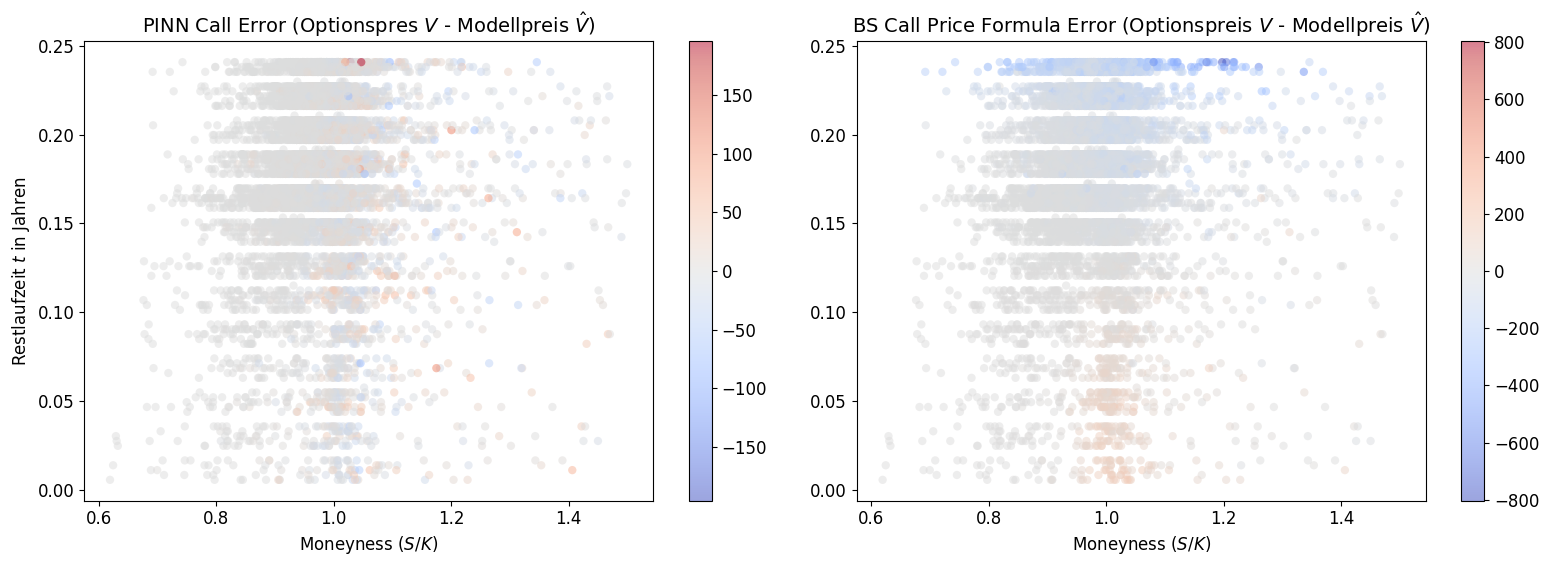

In [26]:
Y_test_flat = Y_test.flatten()
Y_pred_flat = Y_pred.flatten()
bsm_prices_flat = bsm_prices_test.flatten()

Error_PINN = Y_test_flat - Y_pred_flat
Error_BS = Y_test_flat - bsm_prices_flat

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
#fig.suptitle('Vergleich der Optionspreis-Fehler (PINN vs. BS)')

cmap = 'coolwarm'
alpha = 0.5

vmax_pinn = abs(Error_PINN).max()
vmin_pinn = -vmax_pinn

ax = axes[0]
sc1 = ax.scatter(test_df['Moneyness'], test_df['Time'], c=Error_PINN,
                 cmap=cmap, vmin=vmin_pinn, vmax=vmax_pinn, alpha=alpha, edgecolors='none')

ax.set_title('PINN Call Error (Optionspres $V$ - Modellpreis $\hat{V}$)')
ax.set_xlabel('Moneyness $(S/K)$')
ax.set_ylabel('Restlaufzeit $t$ in Jahren')
fig.colorbar(sc1, ax=ax)

vmax_bs = abs(Error_BS).max()
vmin_bs = -vmax_bs

ax = axes[1]
sc2 = ax.scatter(test_df['Moneyness'], test_df['Time'], c=Error_BS,
                 cmap=cmap, vmin=vmin_bs, vmax=vmax_bs, alpha=alpha, edgecolors='none')
ax.set_title('BS Call Price Formula Error (Optionspreis $V$ - Modellpreis $\hat{V}$)')
ax.set_xlabel('Moneyness $(S/K)$')
fig.colorbar(sc2, ax=ax)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig("call_price_error.pdf", bbox_inches="tight")
plt.show()

### FQ3

In [20]:
def classify_market_regime(df, iv_threshold_high=None, iv_threshold_low=None):
    if iv_threshold_high is None:
        iv_threshold_high = df['Implied Volatility'].quantile(0.75)
    if iv_threshold_low is None:
        iv_threshold_low = df['Implied Volatility'].quantile(0.25)
    
    def regime_label(iv):
        if iv > iv_threshold_high:
            return 'High Vol'
        elif iv < iv_threshold_low:
            return 'Low Vol'
        else:
            return 'Normal Vol'
    
    df = df.copy()
    df['Market Regime'] = df['Implied Volatility'].apply(regime_label)
    
    return df

In [21]:
df_market = classify_market_regime(test_df)
print(df_market['Market Regime'].value_counts(normalize=True))
print(df_market.describe().to_markdown())

Market Regime
Normal Vol    0.50
High Vol      0.25
Low Vol       0.25
Name: proportion, dtype: float64
|       |     Spot |   Strike |         Time |         Rate |     Dividend |   Implied Volatility |   Option Price |    Moneyness |
|:------|---------:|---------:|-------------:|-------------:|-------------:|---------------------:|---------------:|-------------:|
| count | 8180     | 8180     | 8180         | 8180         | 8180         |          8180        |      8180      | 8180         |
| mean  | 4024.74  | 4139.04  |    0.175488  |    0.0247665 |    0.0206378 |             0.195212 |        90.4166 |    0.978282  |
| std   |  857.747 |  917.364 |    0.0502373 |    0.0210633 |    0.0031632 |             0.115652 |       180.482  |    0.0855884 |
| min   | 2237.4   | 1800     |    0.0054757 |   -0.00046   |    0.0149893 |             0.04229  |         0.01   |    0.619068  |
| 25%   | 3351.28  | 3390     |    0.158795  |    0.00112   |    0.0181302 |             0.125475 |     

In [22]:
df_low_iv = df_market[df_market['Market Regime']=='Low Vol']
df_high_iv = df_market[df_market['Market Regime']=='High Vol']
df_normal_iv = df_market[df_market['Market Regime']=='Normal Vol']

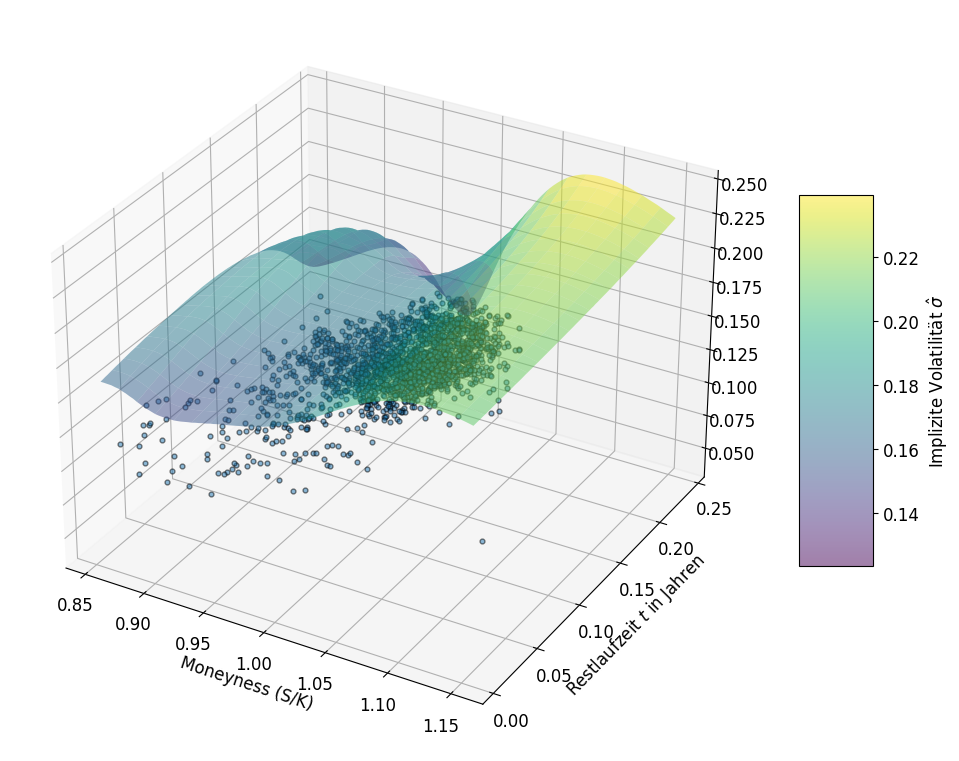

In [27]:
S_mean = df_low_iv['Spot'].mean()
r_mean = df_low_iv['Rate'].mean()
q_mean = df_low_iv['Dividend'].mean()

M_range = np.linspace(df_low_iv['Moneyness'].min(), df_low_iv['Moneyness'].max(), 100)
T_range_vol = np.linspace(df_low_iv['Time'].min(), df_low_iv['Time'].max(), 100)
M_grid, T_grid_vol = np.meshgrid(M_range, T_range_vol)

K_grid_from_M = S_mean / M_grid

K_flat_from_M = K_grid_from_M.flatten()
T_flat_vol = T_grid_vol.flatten()
N_vol = len(K_flat_from_M)

pinn_input_vol = torch.zeros(N_vol, 5, dtype=torch.float32)
pinn_input_vol[:, 0] = torch.full((N_vol,), S_mean)
pinn_input_vol[:, 1] = torch.tensor(K_flat_from_M, dtype=torch.float32)
pinn_input_vol[:, 2] = torch.tensor(T_flat_vol, dtype=torch.float32)
pinn_input_vol[:, 3] = torch.full((N_vol,), r_mean)
pinn_input_vol[:, 4] = torch.full((N_vol,), q_mean)
pinn_input_vol = pinn_input_vol.to(DEVICE)

net_input = pinn_input_vol.to(DEVICE)
net_input_norm = 2 * (net_input - net.x_min) / net.x_range - 1

with torch.no_grad():
    _, _, sigma_pred = net(net_input_norm)
    
vol_surface = sigma_pred.cpu().numpy().reshape(M_grid.shape)

plot_3d_surface_with_scatter(
    grid_x=M_grid, grid_y=T_grid_vol, grid_z=vol_surface,
    scatter_x=df_low_iv['Moneyness'],
    scatter_y=df_low_iv['Time'],
    scatter_z=df_low_iv['Implied Volatility'],
    title='PINN Volatilitätsoberfläche vs. Reale Markt-IV',
    xlabel='Moneyness (S/K)',
    ylabel='Restlaufzeit $t$ in Jahren',
    zlabel='Implizite Volatilität $\hat{\sigma}$'
)

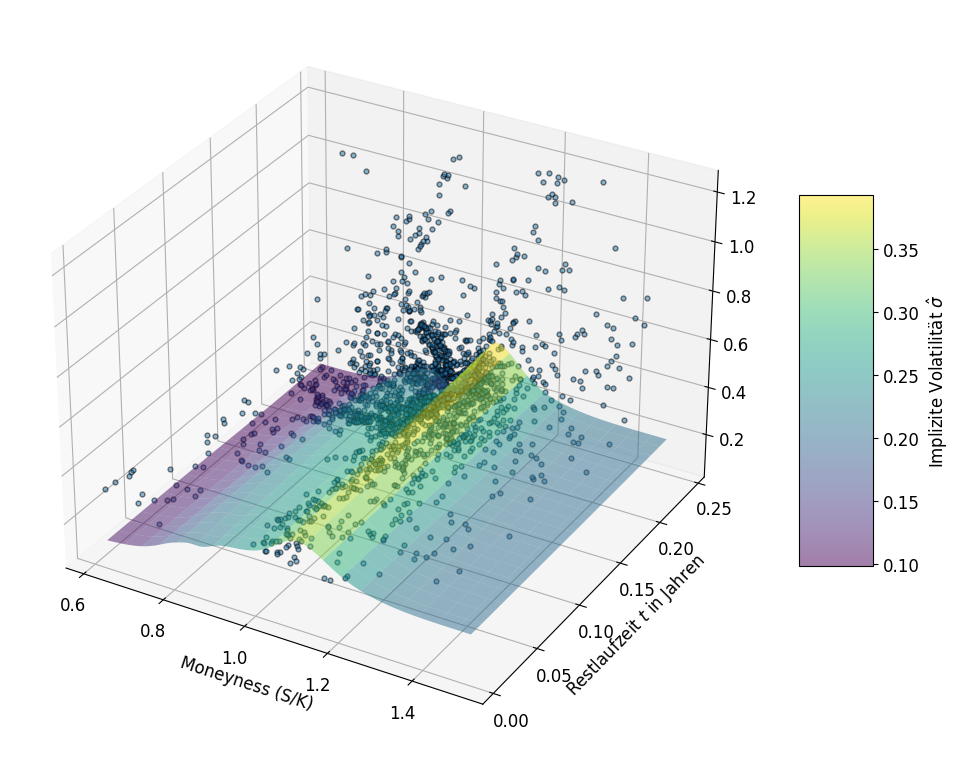

In [26]:
S_mean = df_high_iv['Spot'].mean()
r_mean = df_high_iv['Rate'].mean()
q_mean = df_high_iv['Dividend'].mean()

M_range = np.linspace(df_high_iv['Moneyness'].min(), df_high_iv['Moneyness'].max(), 100)
T_range_vol = np.linspace(df_high_iv['Time'].min(), df_high_iv['Time'].max(), 100)
M_grid, T_grid_vol = np.meshgrid(M_range, T_range_vol)

K_grid_from_M = S_mean / M_grid

K_flat_from_M = K_grid_from_M.flatten()
T_flat_vol = T_grid_vol.flatten()
N_vol = len(K_flat_from_M)

pinn_input_vol = torch.zeros(N_vol, 5, dtype=torch.float32)
pinn_input_vol[:, 0] = torch.full((N_vol,), S_mean)
pinn_input_vol[:, 1] = torch.tensor(K_flat_from_M, dtype=torch.float32)
pinn_input_vol[:, 2] = torch.tensor(T_flat_vol, dtype=torch.float32)
pinn_input_vol[:, 3] = torch.full((N_vol,), r_mean)
pinn_input_vol[:, 4] = torch.full((N_vol,), q_mean)
pinn_input_vol = pinn_input_vol.to(DEVICE)

net_input = pinn_input_vol.to(DEVICE)
net_input_norm = 2 * (net_input - net.x_min) / net.x_range - 1

with torch.no_grad():
    _, _, sigma_pred = net(net_input_norm)
    
vol_surface = sigma_pred.cpu().numpy().reshape(M_grid.shape)

plot_3d_surface_with_scatter(
    grid_x=M_grid, grid_y=T_grid_vol, grid_z=vol_surface,
    scatter_x=df_high_iv['Moneyness'],
    scatter_y=df_high_iv['Time'],
    scatter_z=df_high_iv['Implied Volatility'],
    title='PINN Volatilitätsoberfläche vs. Reale Markt-IV',
    xlabel='Moneyness (S/K)',
    ylabel='Restlaufzeit $t$ in Jahren',
    zlabel='Implizite Volatilität $\hat{\sigma}$'
)

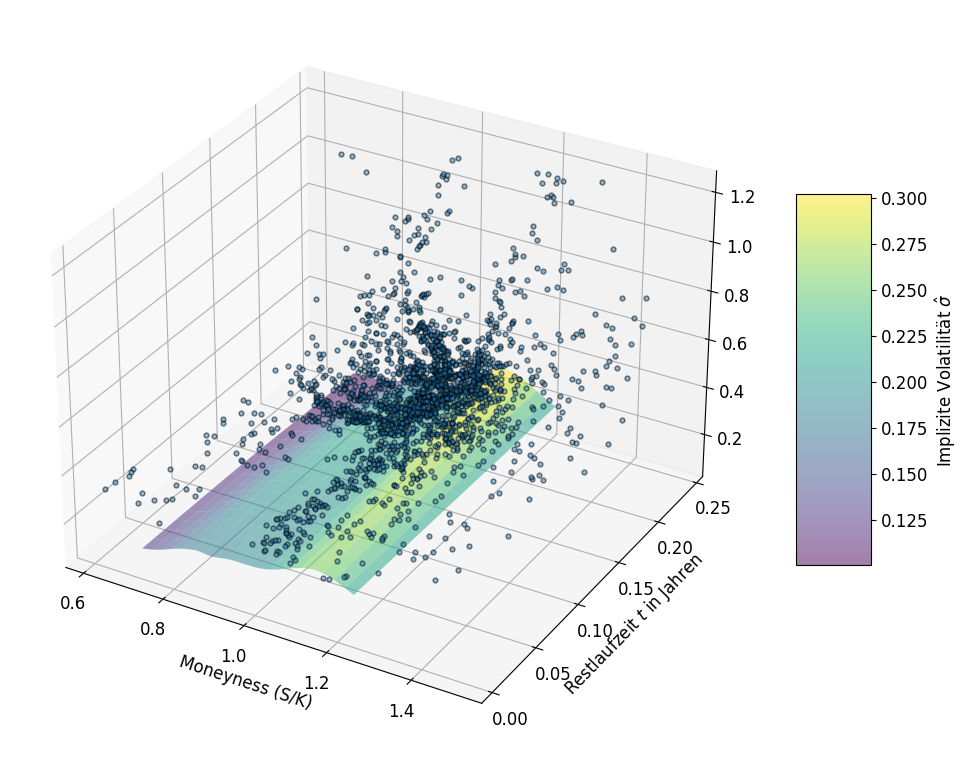

In [25]:
S_mean = df_normal_iv['Spot'].mean()
r_mean = df_normal_iv['Rate'].mean()
q_mean = df_normal_iv['Dividend'].mean()

M_range = np.linspace(df_normal_iv['Moneyness'].min(), df_normal_iv['Moneyness'].max(), 100)
T_range_vol = np.linspace(df_normal_iv['Time'].min(), df_normal_iv['Time'].max(), 100)
M_grid, T_grid_vol = np.meshgrid(M_range, T_range_vol)

K_grid_from_M = S_mean / M_grid

K_flat_from_M = K_grid_from_M.flatten()
T_flat_vol = T_grid_vol.flatten()
N_vol = len(K_flat_from_M)

pinn_input_vol = torch.zeros(N_vol, 5, dtype=torch.float32)
pinn_input_vol[:, 0] = torch.full((N_vol,), S_mean)
pinn_input_vol[:, 1] = torch.tensor(K_flat_from_M, dtype=torch.float32)
pinn_input_vol[:, 2] = torch.tensor(T_flat_vol, dtype=torch.float32)
pinn_input_vol[:, 3] = torch.full((N_vol,), r_mean)
pinn_input_vol[:, 4] = torch.full((N_vol,), q_mean)
pinn_input_vol = pinn_input_vol.to(DEVICE)

net_input = pinn_input_vol.to(DEVICE)
net_input_norm = 2 * (net_input - net.x_min) / net.x_range - 1

with torch.no_grad():
    _, _, sigma_pred = net(net_input_norm)
    
vol_surface = sigma_pred.cpu().numpy().reshape(M_grid.shape)

plot_3d_surface_with_scatter(
    grid_x=M_grid, grid_y=T_grid_vol, grid_z=vol_surface,
    scatter_x=df_high_iv['Moneyness'],
    scatter_y=df_high_iv['Time'],
    scatter_z=df_high_iv['Implied Volatility'],
    title='PINN Volatilitätsoberfläche vs. Reale Markt-IV',
    xlabel='Moneyness (S/K)',
    ylabel='Restlaufzeit $t$ in Jahren',
    zlabel='Implizite Volatilität $\hat{\sigma}$'
)

### Plot Model Architecture

In [ ]:
!pip install torchview
from torchview import draw_graph

In [ ]:
model = net._orig_mod if hasattr(net, "_orig_mod") else net
model.eval()

device = next(model.parameters()).device
dummy = torch.zeros(1, 5, device=device)

g = draw_graph(
    model,
    input_data=dummy,
    expand_nested=True,
    graph_name="pinn_arch",
    depth=4,
    hide_inner_tensors=True
)

g.visual_graph.format = "pdf"
g.visual_graph.render("pinn_architecture", cleanup=True)